# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [26]:
### This agent will learn how to take off
import sys 
import pandas as pd
import numpy as np
from agents.agent import DDPG
from task import TakeOff
import csv

# Starting position
runtime = 5.0
init_pose = np.array([0., 0., np.random.normal(0.5,1), 0., 0., 0.])
num_episodes = 150
target_pos = np.array([0., 0., 10.])
task = TakeOff(init_pose=init_pose, target_pos=target_pos, runtime=runtime)
agent = DDPG(task)

# Setup
data_file = 'data_takeoff.txt'
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 
          'rotor_speed4', 'episode', 'total_reward']

results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(data_file, 'w') as data:
    writer = csv.writer(data)
    writer.writerow(labels)
    for i_episode in range(1, num_episodes+1):
        state = agent.reset_episode() # start a new episode
        while True:
            action = agent.act(state) 
            next_state, reward, done = task.step(action)
            agent.step(action, reward,next_state, done)
            state = next_state
           
            if done:
                to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action) + [i_episode] + [agent.total_reward]
                for ii in range(len(labels)):
                    results[labels[ii]].append(to_write[ii])
                writer.writerow(to_write)
                print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f})".format(
                    i_episode, agent.total_reward, agent.biggest_total_reward), end="")  # [debug]
                break
        sys.stdout.flush()

Episode =  150, score = 252.000 (best = 252.000)

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

No handles with labels found to put in legend.


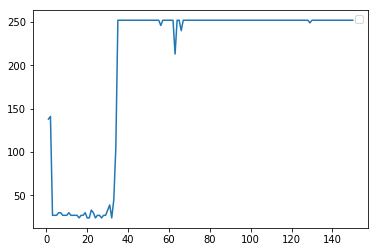

In [27]:
# Total reward plotting
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['episode'], results['total_reward'])
plt.legend()
_ = plt.ylim()

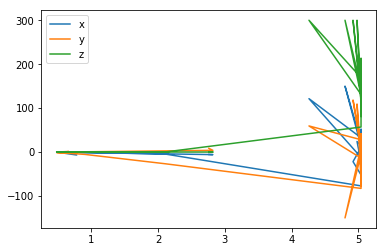

In [28]:

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

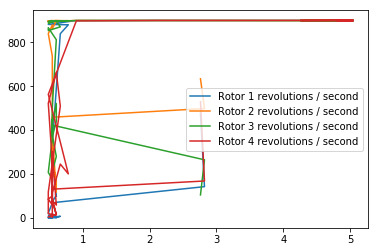

In [29]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

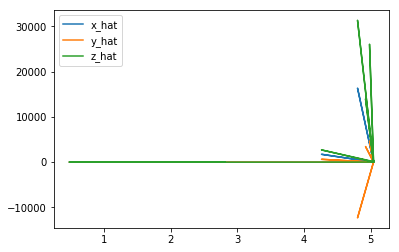

In [30]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

In [41]:
## This agent will learn how to land
import sys 
import pandas as pd
import numpy as np
from agents.agent import DDPG
from task import Landing
import csv

# Starting position
runtime = 5.0
init_pose = np.array([0., 0., 20., 0., 0., 0.])
num_episodes = 150
target_pos = np.array([0., 0., 0.])
task = Landing(init_pose=init_pose, target_pos=target_pos, runtime=runtime)
agent = DDPG(task)

# Setup
data_file = 'data_landing.txt'
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 
          'rotor_speed4', 'episode', 'total_reward']

results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(data_file, 'w') as data:
    writer = csv.writer(data)
    writer.writerow(labels)
    for i_episode in range(1, num_episodes+1):
        state = agent.reset_episode() # start a new episode
        while True:
            action = agent.act(state) 
            next_state, reward, done = task.step(action)
            agent.step(action, reward,next_state, done)
            state = next_state
           
            if done:
                to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action) + [i_episode] + [agent.total_reward]
                for ii in range(len(labels)):
                    results[labels[ii]].append(to_write[ii])
                writer.writerow(to_write)
                print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f})".format(
                    i_episode, agent.total_reward, agent.biggest_total_reward), end="")  # [debug]
                break
        sys.stdout.flush()

Episode =  150, score = 117.000 (best = 252.000)

No handles with labels found to put in legend.


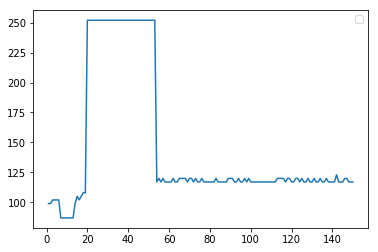

In [42]:
# Reward during simulations
plt.plot(results['episode'], results['total_reward'])
plt.legend()
_ = plt.ylim()

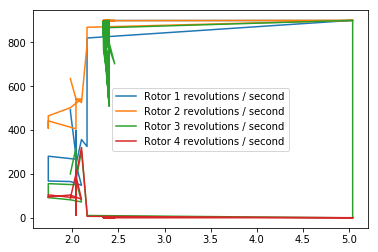

In [43]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

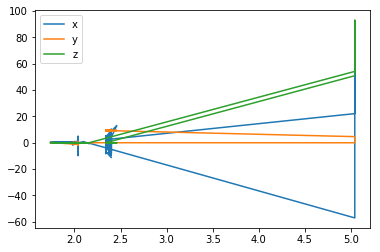

In [44]:
#position during simulation
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

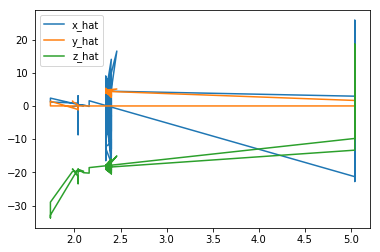

In [45]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:In the task.py file 2 new classes have been added, 1 named TakeOff and the other, named Landing. 
In both cases the reward function is the same. It is a function that calculates the difference of the coordinates between the objective position and the current position. That the sum of the coordinate difference times 0.3(learning rate) is substracted to 1, thus, when the the position of the simulation and the position targeted are the same, the reward will be 1.
In case of being far away, the reward would be negative.

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**: The agent is the proposed actor-critic agent. Its  training is done with MLP structures. 
Different hyperparameters, layer amount and layer sizes have been tried, nonetheless, in view of the increased computational cost and worse performance in some cases I have decided to stick to the initial hyperparameters and structure. 
That is, gamma = 0.99 and tau = 0.01.
The MLPs have different structures in the case of the actor and in the case of the critic:
* The actor: Has 3 fully connected layers of 32,64 and 32, respectively. The last activation function is a sigmoid, whereas therest consist on relu functions.
* The critic: The Network in this case has the same structure following both paths (action and state), the structure is a 2 hidden layer network with sizes of 32 and 64, repectively and relu activations. The final activation has a relu function too.

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**: The initial spike due to the right initial selection was helpful, providing good random exploration. Nonetheless, the large and continuous action space rapidly led to errors and learning experiences.

In the takeoof simulation, before the 40 episode there is and aha moment an in the landing sequence the aha moment occurrs at the 20th episode.
The mean of the rewards of the last 10 episodes for the landing was 252 as it stayed on top (good performance), for the mean of the rewards in the landing case it is calculated bellow. 118.5 seems far from the best 252, but still stays relatively consistent during the last 100 episodes, with suggest that is the best the agent can do.

In [46]:
np.mean(results['total_reward'][-20:])

118.05

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**: The project was a nightmare at sometimes, I decided to stick to the initial simple neural net structures as sometimes the creativity got in the way of the performance.

The part that was the most demanding was getting started, could not figure out what exactly was the goal, but after going through the papers and the supporting material from udacity I realized I had the answers right in front of me.

What I found interesting was that it existed an aha moment, I really believed the progress would be more gradual